# 2024 Winter Introduction to Deep Learning
### Based on Prof. Oh's Youtube Lecture
https://youtube.com/playlist?list=PLvbUC2Zh5oJvByu9KL82bswYT2IKf0K1M

> Assignment #3


*   Youtube Lecture #9-11
*   Written by Seungeun Lee

## 1. Revisiting MLP of Assignment1





*    Reference. https://github.com/Justin-A/DeepLearning101/blob/master/2-1_MNIST_MLP.ipynb

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.1.0+cu121  Device: cpu


In [3]:
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
train_dataset = datasets.MNIST(root = "../data/MNIST",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "../data/MNIST",
                              train = False,
                              transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

100%|██████████| 9912422/9912422 [00:00<00:00, 114230284.44it/s]


Extracting ../data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 12113569.38it/s]

Extracting ../data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27209707.66it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4563000.90it/s]


Extracting ../data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/MNIST/raw



*    The code above loads the data with PyTorch function 'datasets' and 'DataLoader', and works only for MNIST.
*    Can we make our custom datasets and dataloader?
*    Please download a zip file from https://www.kaggle.com/datasets/andrewmvd/animal-faces, and upload the file to your Colab (Google Drive).

In [5]:
# connecting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### (1) Using torchvision.transforms
*     Reference. https://www.kaggle.com/code/eduardignatev/madmo-pro-homework-02#Load-Data

In [7]:
transform_train = transforms.Compose([ ## Data transformation only for train data
    transforms.Resize(size=(256, 256)), ## Resizing the data into (256, 256)
    transforms.RandomRotation(30), ## 30 degree rotation (data augmentation)
    transforms.ToTensor(), ## To 'Pytorch Tensor' -> Pytorch Deep Learning Models like CNN (we'll deal with it later on) get only tensor as an input
])
transform_val = transforms.Compose([ ## Data transformation only for validation (here, it works like the 'test' data...) data
    transforms.Resize(size=(256, 256)), ## Resizing the data into (256, 256)
    transforms.ToTensor() ## To 'Pytorch Tensor'
])

## Please note that the data augmentation technique is not usually implemented to validation/test dataset
## This is why we split transform_train and transform_val -- transform_val does not need
## transforms.RandomRotation(30), ## 30 degree rotation (data augmentation)

train_data = datasets.ImageFolder(root='/content/drive/MyDrive/intro-dl/afhq/train', transform=transform_train)
## Pytorch function datasets.ImageFolder organizes the data in root directory (here, '/content/drive/MyDrive/intro-dl/afhq/train')
## and applies transform_train as defined above.
val_data = datasets.ImageFolder(root='/content/drive/MyDrive/intro-dl/afhq/val', transform=transform_val)
## Pytorch function datasets.ImageFolder organizes the data in root directory (here, '/content/drive/MyDrive/intro-dl/afhq/val')
## and applies transform_val as defined above.

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle = True)
## Pytorch function DataLoader organizes the 'shuffled' (shuffle = True) data in train_data as defined above with the batch size of 16.
val_loader = torch.utils.data.DataLoader(val_data, batch_size=16, shuffle = True)
## Pytorch function DataLoader organizes the 'shuffled' (shuffle = True) data in val_data as defined above with the batch size of 16.

In [11]:
train_data.class_to_idx ## It automatically catches the classes in train_data -> check it by yourself!
## (see /content/drive/MyDrive/intro-dl/afhq/val directory in your Google Drive)

{'cat': 0, 'dog': 1, 'wild': 2}

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
## brings the next images and labels

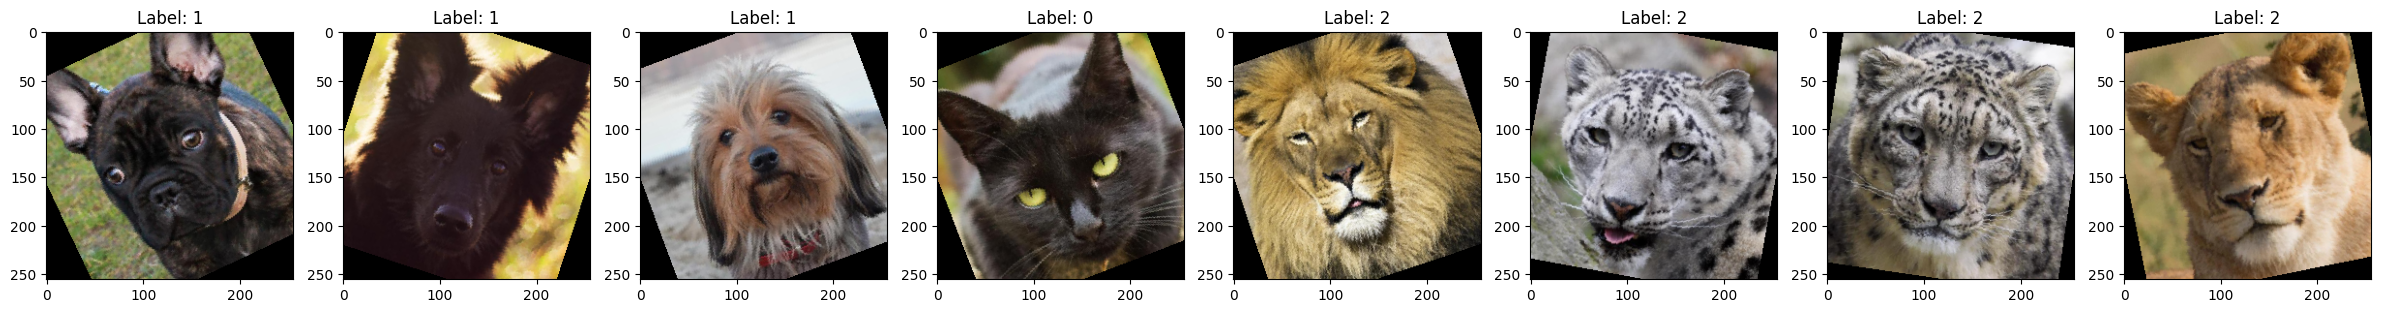

In [10]:
def show_imgs(imgs, labels, preds=None):
    f, axes= plt.subplots(1, 8, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(f'Label: {labels[i].numpy()}')
        if preds != None:
            axes[i].set_xlabel(f'Pred: {np.argmax(preds[i].numpy())}')
    plt.show()

show_imgs(images, labels)

## shows the sample train_data
## 30 degree rotation!

#### (2) Making a customized datasets and dataloader

In [12]:
## We'll use the library 'os' -- please revisit Assignment1

In [13]:
import os

In [14]:
train_cat = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/cat')
train_dog = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/dog')
train_wild = os.listdir('/content/drive/MyDrive/intro-dl/afhq/train/wild')

In [15]:
# WARNING: DO NOT RUN THIS CODE. IT TAKES TOO LONG TIME TO GET THE RESULT.

train_cat_image = []
train_dog_image = []
train_wild_image = []

train_cat_target = []
train_dog_target = []
train_wild_target = []

for i in range(len(train_cat)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/cat', train_cat[i]))
  train_cat_image.append(image)
  train_cat_target.append(0)

for i in range(len(train_dog)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/dog', train_dog[i]))
  train_dog_image.append(image)
  train_dog_target.append(1)

for i in range(len(train_wild)):
  image = plt.imread(os.path.join('/content/drive/MyDrive/intro-dl/afhq/train/wild', train_wild[i]))
  train_wild_image.append(image)
  train_wild_target.append(2)

KeyboardInterrupt: 

### Question 1. Explain os.path.join function.
##### Your Answer.

## 2. Backpropagation and PyTorch Autograd

*   https://kingnamji.tistory.com/44



In [16]:
import torch

In [17]:
w = torch.tensor(3.0, requires_grad = True) ## requires_grad = True: it saves the gradient

In [18]:
y = w**3 + 10

In [19]:
y.backward() ## backward() calculates the derivative

In [20]:
print(f'Differentiating y by w: {w.grad}') ## check it by yourself!! dy/dw = 3*w^2 ..., so

Differentiating y by w: 27.0


In [21]:
## Another example with the loss fuction
import torch
import torch.nn as nn

In [22]:
x = torch.ones(5)  # input
y = torch.zeros(3)  # output

w = torch.randn(5, 3, requires_grad=True) # weight
b = torch.randn(3, requires_grad=True) # bias

In [23]:
z = torch.matmul(x, w) + b # z = wx + b
loss_fn = nn.MSELoss() # loss function

In [24]:
loss = loss_fn(z, y)

loss.backward()

In [25]:
print(f'Differentiating loss by w :\n {w.grad}')
print(f'Differentiating loss by b : {b.grad}')

Differentiating loss by w :
 tensor([[ 0.8417,  0.2076, -2.9975],
        [ 0.8417,  0.2076, -2.9975],
        [ 0.8417,  0.2076, -2.9975],
        [ 0.8417,  0.2076, -2.9975],
        [ 0.8417,  0.2076, -2.9975]])
Differentiating loss by b : tensor([ 0.8417,  0.2076, -2.9975])


### Question 2. PyTorch Autograd and DataLoader
##### Read the following document and summarize it.
##### https://velog.io/@euisuk-chung/%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%ED%8C%8C%EC%9D%B4%ED%86%A0%EC%B9%98-%EA%B8%B0%EC%B4%88-%EC%9A%94%EC%86%8C-Autograd%EB%9E%80

## 3. Vanishing Gradient Problem

In [ ]:
# Although we usually build DL models based on PyTorch,
# we sometimes need to use TensorFlow upon your colleagues' requests

In [26]:
## Let's take a look at the vanishing gradient problem w/ Tensorflow

*    Reference. https://github.com/bhattbhavesh91/vanishing-gradient-problem/blob/master/vanishing-gradient-notebook.ipynb

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import warnings
from matplotlib.colors import ListedColormap
from mlxtend.plotting import plot_decision_regions
from pylab import rcParams
from sklearn.datasets import make_circles, make_moons
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

In [28]:
np.set_printoptions(suppress=True)
zero_one_colourmap = ListedColormap(('white', 'red'))
rcParams['figure.figsize'] = 14, 7
rcParams['axes.facecolor'] = '#383838'

In [29]:
X, y = make_circles(n_samples = 1000,
                    factor=0.85,
                    random_state=2021,
                    noise=0.1)

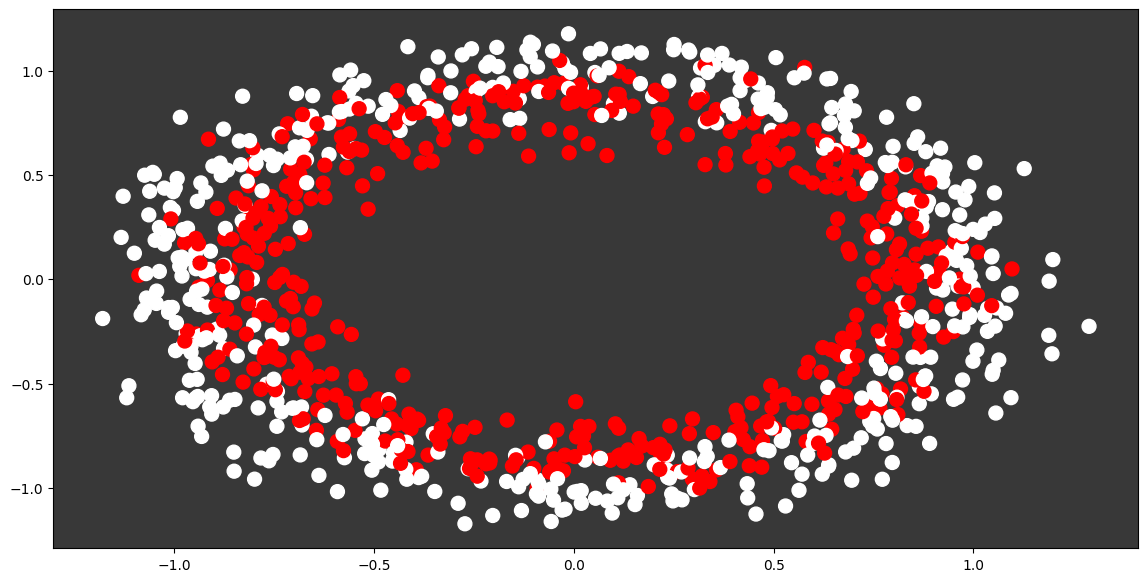

In [30]:
plt.scatter(X[:,0],X[:,1],
            c=y, s=100,
            cmap = zero_one_colourmap)
plt.show()

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.33,
                                                    random_state=42)

In [32]:
def get_model(inp_activation):
  model = Sequential()
  model.add(Dense(10,input_dim=2, activation=inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(10, activation = inp_activation))
  model.add(Dense(1, activation="sigmoid"))
  model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

In [33]:
def change_in_weight_gradient(old_weight, new_weight, learning_rate):
  gradient = (old_weight - new_weight)/ learning_rate
  pct_change_weight = abs(100*(old_weight - new_weight)/ old_weight)
  return gradient, pct_change_weight

*     Sigmoid Model

In [34]:
sigmoid_model = get_model("sigmoid")

In [35]:
sigmoid_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                                                 
 dense_5 (Dense)             (None, 10)                110       
                                                                 
 dense_6 (Dense)             (None, 10)                1

In [36]:
sigmoid_model_first_layer_weights = sigmoid_model.get_weights()[0][0]

In [37]:
sigmoid_model_first_layer_weights

array([ 0.38979787,  0.53081053, -0.22255304,  0.04911101, -0.6566319 ,
        0.23750067,  0.370346  ,  0.31262833,  0.01206243, -0.38514766],
      dtype=float32)

In [38]:
sigmoid_history = sigmoid_model.fit(X_train, y_train, epochs = 1,
                            validation_data = (X_test, y_test))

21/21 [==============================] - 3s 20ms/step - loss: 0.7485 - accuracy: 0.4881 - val_loss: 0.7145 - val_accuracy: 0.5242


In [39]:
sigmoid_model_first_layer_weights_updated = sigmoid_model.get_weights()[0][0]

In [40]:
sigmoid_model_first_layer_weights_updated

array([ 0.3897967 ,  0.53081226, -0.22255327,  0.04911157, -0.6566317 ,
        0.23750061,  0.37034568,  0.3126283 ,  0.01206412, -0.38514912],
      dtype=float32)

In [41]:
s_gradient, s_weight_change = change_in_weight_gradient(sigmoid_model_first_layer_weights,
                                                        sigmoid_model_first_layer_weights_updated,
                                                        sigmoid_model.optimizer.get_config()["learning_rate"])

In [42]:
s_gradient

array([ 0.00116229, -0.00172853,  0.00022352, -0.00055879, -0.00017881,
        0.0000596 ,  0.00032783,  0.0000298 , -0.00168569,  0.00146031],
      dtype=float32)

In [44]:
s_weight_change

array([0.00029818, 0.00032564, 0.00010043, 0.00113782, 0.00002723,
       0.0000251 , 0.00008852, 0.00000953, 0.01397474, 0.00037916],
      dtype=float32)

*     ReLU Model

In [46]:
activation_model = get_model("relu")

In [47]:
activation_model_old_first_layer_weight = activation_model.get_weights()[0][0]
activation_model_old_first_layer_weight

array([-0.23568803, -0.15778428,  0.6531084 ,  0.25330257, -0.6535361 ,
        0.30163318, -0.0555433 , -0.14649534,  0.01714146,  0.5010517 ],
      dtype=float32)

In [48]:
activation_history = activation_model.fit(X_train, y_train, epochs = 1,
                                          validation_data = (X_test, y_test))

21/21 [==============================] - 3s 24ms/step - loss: 0.6934 - accuracy: 0.4970 - val_loss: 0.6935 - val_accuracy: 0.4758


In [49]:
activation_model_updated_first_layer_weight = activation_model.get_weights()[0][0]

In [50]:
activation_model_updated_first_layer_weight

array([-0.23071393, -0.1663218 ,  0.6493581 ,  0.26302853, -0.6588339 ,
        0.30232015, -0.05378507, -0.14362498,  0.01472999,  0.50013953],
      dtype=float32)

In [51]:
relu_gradient, relu_weight_change = change_in_weight_gradient(activation_model_old_first_layer_weight,
                                                              activation_model_updated_first_layer_weight,
                                                              activation_model.optimizer.get_config()["learning_rate"])

In [52]:
relu_gradient

array([-4.974097 ,  8.537516 ,  3.750324 , -9.725958 ,  5.297839 ,
       -0.6869733, -1.7582289, -2.8703659,  2.4114726,  0.9121894],
      dtype=float32)

In [53]:
relu_weight_change

array([ 2.1104581 ,  5.4108787 ,  0.5742269 ,  3.8396602 ,  0.81064224,
        0.22775126,  3.1655102 ,  1.9593564 , 14.068069  ,  0.18205495],
      dtype=float32)

### Question 3.
##### Check out this YouTube and write a line-by-line explanation of the code above -- ChatGPT allowed.
##### https://youtube.com/watch?v=wTyZqtJyp5g

## 4. Regression
*     Reference. https://www.geeksforgeeks.org/linear-regression-python-implementation/

In [58]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, metrics

In [59]:
data_url = "http://lib.stat.cmu.edu/datasets/boston" ## Loading Boston Housing Dataset -- a famous dataset for linear regression
raw_df = pd.read_csv(data_url, sep="\s+",
           skiprows=22, header=None)

In [61]:
X = np.hstack([raw_df.values[::2, :],
        raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [62]:
X

array([[  0.00632,  18.     ,   2.31   , ...,  15.3    , 396.9    ,
          4.98   ],
       [  0.02731,   0.     ,   7.07   , ...,  17.8    , 396.9    ,
          9.14   ],
       [  0.02729,   0.     ,   7.07   , ...,  17.8    , 392.83   ,
          4.03   ],
       ...,
       [  0.06076,   0.     ,  11.93   , ...,  21.     , 396.9    ,
          5.64   ],
       [  0.10959,   0.     ,  11.93   , ...,  21.     , 393.45   ,
          6.48   ],
       [  0.04741,   0.     ,  11.93   , ...,  21.     , 396.9    ,
          7.88   ]])

In [63]:
y

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [64]:
## Quick Question.
## Explain np.hstack, np.vstack, np.concatenate with proper examples. Google it and write your own answer.

## Your Answer
##

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

In [66]:
## Quick Question.
## Explain X, y, and train_test_split function above.

## Your Answer
##

In [67]:
reg = linear_model.LinearRegression() ## LR Model of Scikit-learn
reg.fit(X_train, y_train)

LinearRegression()

In [69]:
# regression coefficients
print('Coefficients: ', reg.coef_)

# variance score: 1 means perfect prediction
print('Variance score: {}'.format(reg.score(X_test, y_test)))

Coefficients:  [ -0.0895714    0.06731329   0.05046492   2.18579583 -17.20539752
   3.63606995   0.0020558   -1.36602886   0.28957672  -0.01227001
  -0.83488185   0.00940361  -0.50400832]
Variance score: 0.720905667266174


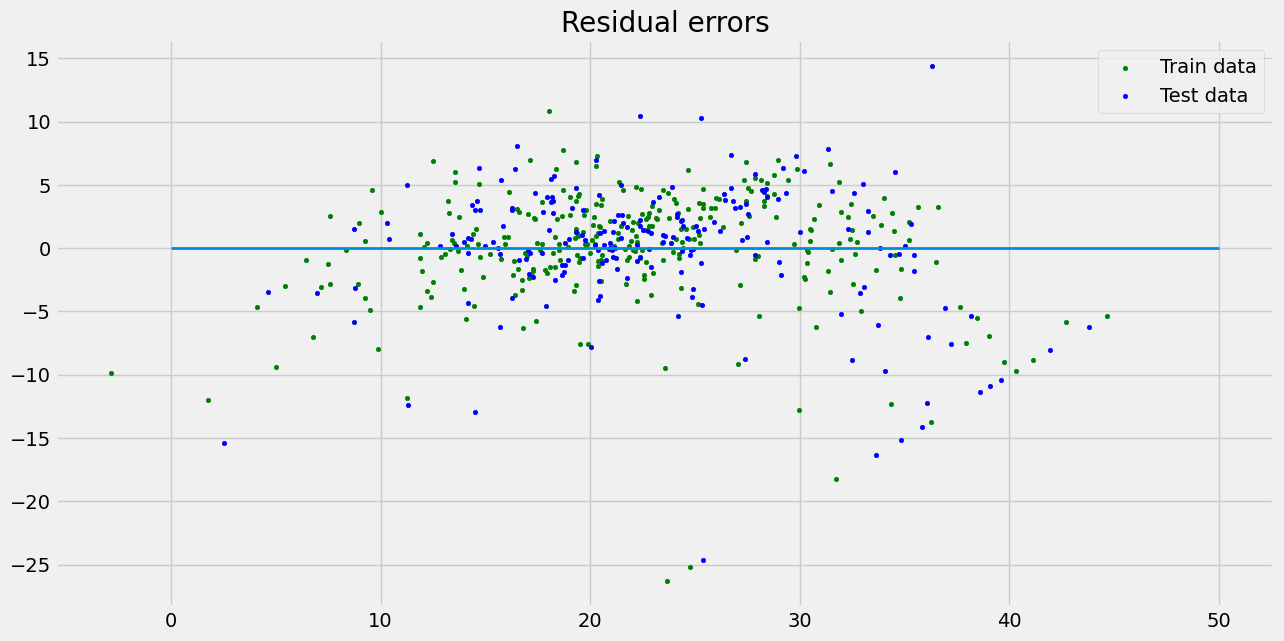

In [70]:
# plot for residual error

# setting plot style
plt.style.use('fivethirtyeight')

# plotting residual errors in training data
plt.scatter(reg.predict(X_train),
            reg.predict(X_train) - y_train,
            color="green", s=10,
            label='Train data')

# plotting residual errors in test data
plt.scatter(reg.predict(X_test),
            reg.predict(X_test) - y_test,
            color="blue", s=10,
            label='Test data')

# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=50, linewidth=2)

# plotting legend
plt.legend(loc='upper right')

# plot title
plt.title("Residual errors")

# method call for showing the plot
plt.show()

## 5. Activation Function
*    Reference. https://sanghyu.tistory.com/182

In [71]:
## 1. Sigmoid
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Sigmoid() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [72]:
## 2. Tanh [Hyperbolic tangent]
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.Tanh() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [73]:
## 3. ReLU
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.ReLU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

In [74]:
## 4. Leaky ReLU
import torch
import torch.nn as nn

class DenseBlock(nn.Module):
	def __init__(self, in_dim, out_dim):
		super(DenseBlock, self).__init__()
		self.dense = nn.Linear(in_dim, out_dim)
		self.act = nn.LeakyReLU() # activation function

	def forward(self, x):
		out = self.act(self.dense(x))
		return out

### Question 4.
##### Write the code for Maxout, ELU, and GELU in the same format.
##### For GELU, please search what GELU is and write your own answer.

### The End.

##### Please upload your Colab file @Github https://github.com/duneag2/intro-dl/tree/main/Assignment3

*   First, make your folder by your name (e.g. seungeun)
*   Then upload your "Jupyter Notebook" file under that directory

###### Need Help?



*   Please refer to this link https://yeko90.tistory.com/entry/%ED%8C%8C%EC%9D%B4%EC%8D%AC-colab%EC%BD%94%EB%9E%A9%EC%97%90%EC%84%9C-%EC%95%95%EC%B6%95%ED%8C%8C%EC%9D%BC-%ED%92%80%EA%B8%B0 OR
*   Just save your Jupyter Notebook (.ipynb) file in here (colab) and upload via 'Add file' - 'Upload files' https://nthree.tistory.com/60